# NLP: Musical instrument reviews on Amazon
(Kaggle)<br><br>
**Objective** is to build a sentiment analysis of customer reviews, verified against the actual customer rating. Three classes of sentiment are envisaged: "Fine" which correlates with a score 5, "Niggle" which indicates there is a small area of dissatisfaction or room for improvement, indicated by a score 4, and "Problem" indicated by a score of 1-3.

The model will be built using the spaCy package.

**Contents:**<a id='s0'></a>
1. [Exploratory data analysis](#s1)
2. [Data transformation](#s2)
3. [Model building](#s3)
4. [Evaluation](#s4)
5. [Conclusions](#s5)

## 1. Exploratory data analysis<a id='s1'></a>

In [1]:
import pandas as pd
reviews=pd.read_csv("musical_instruments_reviews.csv")
reviews = reviews[['reviewText','overall']].dropna()
reviews['text_length'] = [len(x) for x in reviews['reviewText']]
reviews.head(10)

,reviewText,overall,text_length
0,"Not much to write about here, but it does exac...",5.0,268
1,The product does exactly as it should and is q...,5.0,544
2,The primary job of this device is to block the...,5.0,436
3,Nice windscreen protects my MXL mic and preven...,5.0,206
4,This pop filter is great. It looks and perform...,5.0,159
5,So good that I bought another one. Love the h...,5.0,234
6,"I have used monster cables for years, and with...",5.0,191
7,I now use this cable to run from the output of...,3.0,845
8,Perfect for my Epiphone Sheraton II. Monster ...,5.0,201
9,Monster makes the best cables and a lifetime w...,5.0,217


In [2]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10254 entries, 0 to 10260
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewText   10254 non-null  object 
 1   overall      10254 non-null  float64
 2   text_length  10254 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 320.4+ KB


In [3]:
print(f"Review text ranges from {min(reviews['text_length'])} to {max(reviews['text_length'])} characters") 

Review text ranges from 9 to 11310 characters


In [4]:
reviews.overall.value_counts()

5.0    6932
4.0    2083
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

Nothing is noteworthy or requiring attention from the EDA, except that some of the reviews are extremely lengthy.

## 2. Data transformation<a id='s2'></a>

spaCy requires a list of string texts, and a corresponding list of dictionaries, where each dictionary has a boolean entry for each possible category. The data will be split at this point into a train set, a tune set and a test set.

In [71]:
import random
reviews['tuples'] = reviews.apply(lambda row: (row['reviewText'],row['overall']), axis=1)
data = reviews['tuples'].tolist()
split_base = 0.8

# Create template dictionary containing the three categories
cat_blank = {"Problem": False, "Niggle": False, "Fine":False}

# Shuffle the data and separate out components
random.shuffle(data)
texts, labels = zip(*data)

# create the dictionary of categories for each review
cats = []
scoring = {5: "Fine", 4: "Niggle", 3: "Problem", 2: "Problem", 1: "Problem"}
for y in labels:
    cat = cat_blank.copy()
    cat[scoring[y]] = True
    cats.append(cat)
    
# Splitting off the test data
split = int(len(data) * split_base)
(train_texts, train_cats), (test_texts, test_cats) =  (texts[:split], cats[:split]), (texts[split:], cats[split:])

# Splitting off the tuning data
split = int(len(train_cats) * split_base)
(train_texts, train_cats), (tune_texts, tune_cats) =  (train_texts[:split], train_cats[:split]), (train_texts[split:], train_cats[split:])


# Recombine texts and cats in preparation for minibatching
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))

## 3. Model building<a id='s3'></a>

In preparation for buiding the model we will create three utility functions: an evaluation function to monitor model performance, a wrapper function to train the models, and a plotting function to show the results.

In [76]:
import spacy
from spacy.util import minibatch, compounding
import matplotlib.pyplot as plt
%matplotlib inline

# Instantiate the nlp object on English language model
nlp=spacy.load("en_core_web_sm")
runs = []

### 3.1 Evaluation function
This function will be run on the model at each iteration on both train and test sets. It will return overall mean accuracy and an f-score for each category.

In [77]:
def evaluate(tokenizer, textcat, texts, cats):
    
# Convert text list into a set of spaCy docs
    docs = (tokenizer(text) for text in texts)
    
# Accumulators for true and false positives and negatives and f-score
    tp = {"Problem": 0, "Niggle": 0, "Fine": 0}
    fp = tp.copy()
    fn = tp.copy()
    tn = tp.copy()
    f_score = tp.copy()
    
# Apply model to docs to get predicted category
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        pred = max(doc.cats, key = doc.cats.get)
        
# for each category accumulate tp, fp, tn, fn as appropriate
        for label in doc.cats.keys():
            if label == pred:
                if gold[label] == 1:
                    tp[label] += 1.0
                else:
                    fp[label] += 1.0
            else:
                if gold[label] == 1:
                    fn[label] += 1.0
                else:
                    tn[label] += 1.0
# Calculate mean_accuracy and f-score for each category
    count_right = 0
    count_wrong = 0
    f_score["Mean"] = 0.0
    for label in tp.keys():
        count_right += tp[label] + tn[label]
        count_wrong += fp[label] + fn[label]
        if (tp[label] + fp[label]) == 0:
            precision = 0
        else:
            precision = tp[label] / (tp[label] + fp[label])
        if (tp[label] + fn[label]) == 0:
            recall = 0
        else:
            recall = tp[label] / (tp[label] + fn[label])
        if (precision + recall) == 0:
            f_score[label] = 0.0
        else:
            f_score[label] = 2 * (precision * recall) / (precision + recall)
        f_score["Mean"] += f_score[label]
    mean_accuracy = count_right/(count_right + count_wrong)
    f_score["Mean"] = f_score["Mean"]/len(tp)
    return {"mean_accuracy": mean_accuracy, "f_score": f_score}


### 3.2 Model building wrapper
This is a wrapper function to enable the model to be built repeatedly with different architectures, drop out rates, iterations and batch sizes.

In [78]:
def run_model(nlp, architecture, drop=0.2, n_iter=10, min_batch=4.0):
    
# Clear the categorization pipe
    if 'textcat' in nlp.pipe_names:
        nlp.remove_pipe('textcat')
        
# Create a new pipe with three exclusive classes
    textcat=nlp.create_pipe( "textcat",
                        config={"exclusive_classes": True, "architecture": architecture})
    nlp.add_pipe(textcat, last=True)
    textcat.add_label("Problem")
    textcat.add_label("Niggle")
    textcat.add_label("Fine")
    
# Disable other components so that only textcat is trained
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):
        
# Begin the training cycle
        optimizer = nlp.begin_training()
        print("Training the model...")
        print("Iter\tLOSS\tmean_accuracy\tf_score (tune):\t\t\tf_score (train):")
        print("\t\t\t\tProblem\tNiggle\tFine\tMean\tProblem\tNiggle\tFine\tMean")
        
# Performing training and accumulate scores
        tune_history = []
        train_history = []
        for i in range(n_iter):
            losses = {}
            batches = minibatch(train_data, size=compounding(min_batch, 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=drop,losses=losses)
                
# Call the evaluate() function and printing the scores
            train_scores = evaluate(nlp.tokenizer, textcat, train_texts, train_cats)
            tune_scores = evaluate(nlp.tokenizer, textcat, tune_texts, tune_cats)
            train_history.append(train_scores['f_score'])
            tune_history.append(tune_scores['f_score'])
            print(f"{i+1}\t{losses['textcat']:.3f}\t{tune_scores['mean_accuracy']:.3f}\t\t"
                  f"{tune_scores['f_score']['Problem']:.3f}\t{tune_scores['f_score']['Niggle']:.3f}\t"
                  f"{tune_scores['f_score']['Fine']:.3f}\t{tune_scores['f_score']['Mean']:.3f}\t{train_scores['f_score']['Problem']:.3f}\t"
                  f"{train_scores['f_score']['Niggle']:.3f}\t{train_scores['f_score']['Fine']:.3f}\t{train_scores['f_score']['Mean']:.3f}")
    
    best_iter = max(range(len(tune_history)), key=lambda index: tune_history[index]['Mean'])
    best_f = tune_history[best_iter]["Mean"]
    runs.append({"model":nlp._meta['name'], "architecture":architecture, "drop":drop, "min_batch":min_batch, "best_f":best_f, "best_iter":best_iter+1 })
    print(f'\nBest mean f-score is: {best_f:.3} after {best_iter+1} iterations')
    return (train_history, tune_history)

### 3.3 Iteration plot function
This function enables us to follow performance of the model through successive training iterations

In [79]:
def plot_history(train_history, tune_history):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1,4,1)
    ax2 = fig.add_subplot(1,4,2)
    ax3 = fig.add_subplot(1,4,3)
    ax4 = fig.add_subplot(1,4,4)

    ax1.set_title('Problem f-score')
    ax1.plot([d['Problem'] for d in train_history], color='blue', label='train')
    ax1.plot([d['Problem'] for d in tune_history], color='red', label='tune')
    ax1.set_ylim([0, 1])
    ax1.legend()
    ax2.set_title('Niggle f-score')
    ax2.plot([d['Niggle'] for d in train_history], color='blue', label='train')
    ax2.plot([d['Niggle'] for d in tune_history], color='red', label='tune')
    ax2.set_ylim([0, 1])
    ax2.legend()
    ax3.set_title('Fine f-score')
    ax3.plot([d['Fine'] for d in train_history], color='blue', label='train')
    ax3.plot([d['Fine'] for d in tune_history], color='red', label='tune')
    ax3.set_ylim([0, 1])
    ax3.legend()
    ax4.set_title('Mean f-score')
    ax4.plot([d['Mean'] for d in train_history], color='blue', label='train')
    ax4.plot([d['Mean'] for d in tune_history], color='red', label='tune')
    ax4.set_ylim([0, 1])
    ax3.legend()
    plt.ylim([0,1])
    plt.show()

### 3.3 Model runs

Run on spaCy standard CNN architecture for text categorization

In [80]:
train_history, tune_history = run_model(nlp, "spacy.TextCatCNN.v2", drop=0.2, n_iter=15, min_batch=4.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	16.332	0.792		0.010	0.000	0.815	0.275	0.002	0.000	0.808	0.270
2	15.578	0.756		0.276	0.177	0.792	0.415	0.409	0.214	0.819	0.481
3	14.699	0.767		0.373	0.163	0.804	0.447	0.504	0.224	0.861	0.529
4	13.264	0.771		0.402	0.199	0.807	0.469	0.543	0.252	0.888	0.561
5	12.075	0.773		0.387	0.273	0.807	0.489	0.608	0.412	0.905	0.642
6	10.900	0.772		0.344	0.251	0.807	0.467	0.647	0.478	0.929	0.685
7	10.190	0.782		0.255	0.312	0.818	0.462	0.632	0.589	0.936	0.719
8	9.381	0.776		0.297	0.309	0.803	0.470	0.713	0.618	0.944	0.758
9	8.606	0.763		0.256	0.305	0.799	0.453	0.719	0.657	0.947	0.774
10	8.266	0.756		0.308	0.299	0.786	0.464	0.757	0.655	0.952	0.788
11	7.923	0.762		0.325	0.301	0.787	0.471	0.803	0.731	0.959	0.831
12	7.206	0.773		0.308	0.332	0.793	0.478	0.824	0.748	0.960	0.844
13	6.656	0.766		0.316	0.331	0.786	0.478	0.888	0.822	0.967	0.892
14	5.487	0.745		0.347	0.339	0.758	0

And plot:

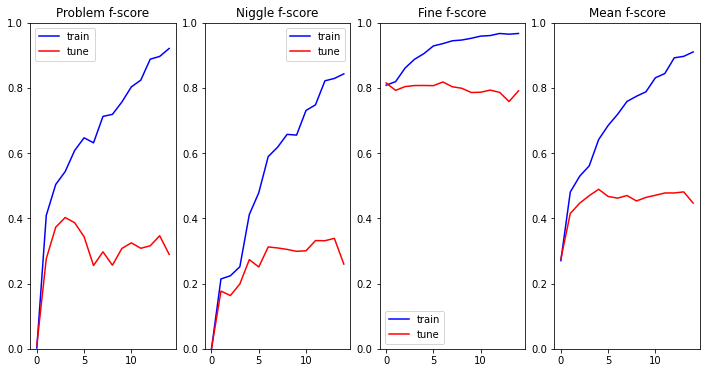

In [81]:
plot_history(train_history, tune_history)

Does large language model give any improvements?

In [82]:
nlp2 =spacy.load("en_core_web_lg")
train_history, tune_history = run_model(nlp2, "spacy.TextCatCNN.v2", drop=0.2, n_iter=15, min_batch=4.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	16.302	0.790		0.048	0.000	0.814	0.287	0.050	0.000	0.809	0.287
2	15.295	0.800		0.430	0.000	0.833	0.421	0.495	0.000	0.849	0.448
3	13.715	0.793		0.473	0.206	0.830	0.503	0.584	0.294	0.888	0.588
4	12.531	0.799		0.466	0.336	0.832	0.545	0.672	0.470	0.907	0.683
5	10.969	0.796		0.425	0.338	0.827	0.530	0.695	0.599	0.927	0.740
6	9.713	0.790		0.441	0.376	0.816	0.544	0.763	0.667	0.936	0.789
7	8.777	0.784		0.429	0.383	0.809	0.540	0.768	0.683	0.940	0.797
8	8.286	0.763		0.433	0.358	0.781	0.524	0.822	0.733	0.945	0.834
9	7.500	0.777		0.425	0.371	0.797	0.531	0.864	0.806	0.962	0.877
10	6.760	0.783		0.459	0.307	0.803	0.523	0.892	0.812	0.963	0.889
11	5.698	0.780		0.446	0.278	0.804	0.509	0.897	0.807	0.962	0.889
12	4.953	0.767		0.413	0.324	0.787	0.508	0.913	0.861	0.970	0.915
13	4.599	0.742		0.397	0.325	0.752	0.491	0.922	0.874	0.971	0.922
14	4.521	0.738		0.380	0.343	0.747	0.4

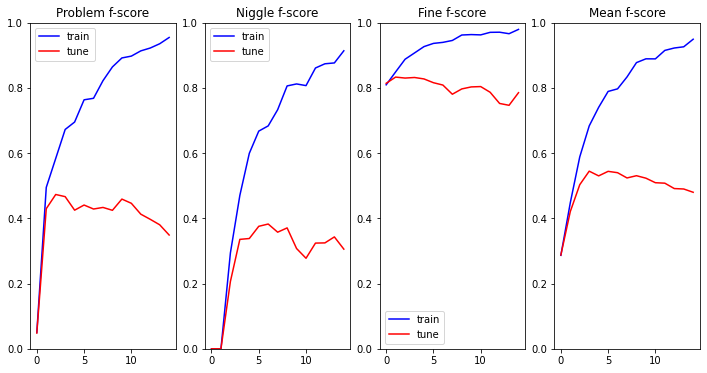

In [83]:
plot_history(train_history, tune_history)

Reduce minimum batch size - does this give us better performance?

In [84]:
train_history, tune_history = run_model(nlp, "spacy.TextCatCNN.v2", drop=0.2, n_iter=15, min_batch=2.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	84.111	0.790		0.288	0.006	0.816	0.370	0.321	0.003	0.821	0.382
2	78.918	0.776		0.408	0.000	0.809	0.405	0.470	0.000	0.841	0.437
3	73.175	0.791		0.357	0.047	0.824	0.409	0.542	0.079	0.865	0.495
4	66.475	0.776		0.388	0.250	0.808	0.482	0.591	0.358	0.889	0.612
5	59.625	0.768		0.363	0.277	0.800	0.480	0.667	0.491	0.905	0.688
6	53.547	0.761		0.375	0.267	0.793	0.478	0.698	0.538	0.920	0.719
7	52.862	0.754		0.346	0.315	0.778	0.480	0.705	0.539	0.920	0.721
8	48.452	0.762		0.343	0.310	0.791	0.481	0.723	0.607	0.933	0.755
9	47.358	0.770		0.333	0.308	0.797	0.479	0.756	0.651	0.943	0.783
10	42.793	0.760		0.365	0.303	0.786	0.485	0.754	0.636	0.948	0.779
11	39.995	0.766		0.368	0.321	0.786	0.492	0.794	0.680	0.952	0.809
12	36.885	0.773		0.365	0.303	0.800	0.489	0.814	0.708	0.959	0.827
13	31.844	0.779		0.331	0.284	0.805	0.473	0.857	0.744	0.953	0.851
14	30.948	0.774		0.310	0.341	

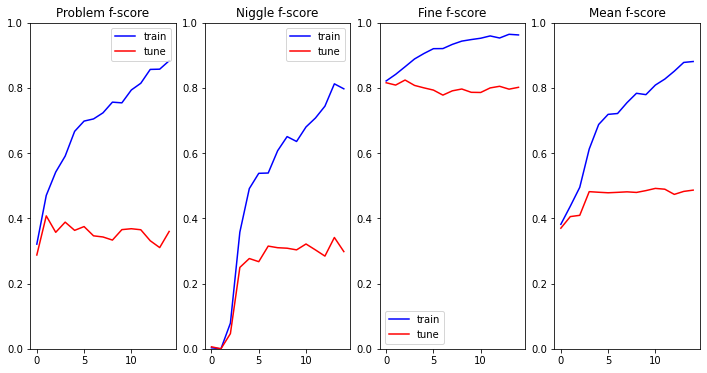

In [85]:
plot_history(train_history, tune_history)

Increase drop rate to slow down overtraining

In [86]:
train_history, tune_history = run_model(nlp, "spacy.TextCatCNN.v2", drop=0.3, n_iter=20, min_batch=2.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	85.390	0.792		0.000	0.000	0.815	0.272	0.002	0.000	0.808	0.270
2	82.043	0.788		0.219	0.018	0.819	0.352	0.302	0.030	0.822	0.385
3	77.882	0.798		0.305	0.047	0.825	0.392	0.393	0.060	0.839	0.431
4	71.902	0.801		0.374	0.084	0.830	0.429	0.497	0.102	0.859	0.486
5	66.608	0.798		0.361	0.145	0.829	0.445	0.557	0.226	0.878	0.553
6	63.413	0.797		0.382	0.164	0.831	0.459	0.590	0.273	0.888	0.583
7	59.302	0.794		0.294	0.248	0.825	0.456	0.611	0.461	0.895	0.656
8	53.160	0.788		0.309	0.255	0.817	0.460	0.733	0.608	0.912	0.751
9	48.903	0.788		0.297	0.217	0.819	0.444	0.687	0.519	0.912	0.706
10	48.253	0.785		0.424	0.275	0.809	0.503	0.774	0.635	0.929	0.779
11	45.782	0.780		0.389	0.253	0.808	0.483	0.794	0.653	0.932	0.793
12	44.287	0.794		0.314	0.245	0.823	0.460	0.809	0.651	0.928	0.796
13	37.580	0.772		0.381	0.298	0.793	0.491	0.833	0.748	0.948	0.843
14	34.748	0.784		0.354	0.224	

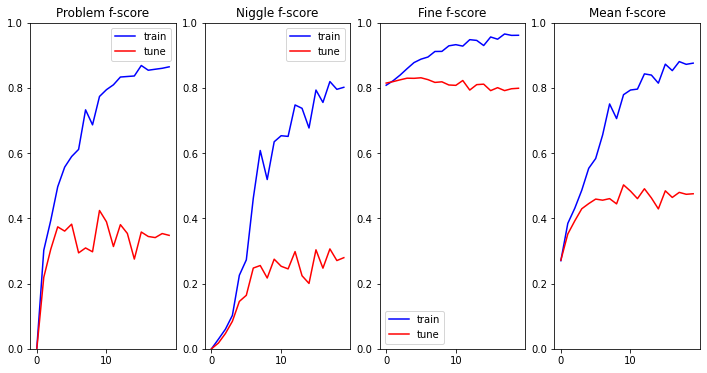

In [87]:
plot_history(train_history, tune_history)

Perhaps increasing the drop rate even further would help?

In [88]:
train_history, tune_history = run_model(nlp, "spacy.TextCatCNN.v2", drop=0.4, n_iter=20, min_batch=2.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	86.859	0.792		0.000	0.000	0.815	0.272	0.000	0.000	0.808	0.269
2	83.188	0.792		0.000	0.000	0.815	0.272	0.000	0.000	0.808	0.269
3	78.634	0.797		0.215	0.117	0.827	0.386	0.239	0.139	0.827	0.402
4	75.828	0.790		0.010	0.218	0.826	0.351	0.064	0.347	0.846	0.419
5	70.743	0.787		0.197	0.269	0.822	0.429	0.321	0.465	0.861	0.549
6	66.706	0.773		0.358	0.282	0.805	0.482	0.573	0.516	0.874	0.654
7	63.202	0.781		0.341	0.292	0.809	0.481	0.628	0.574	0.889	0.697
8	61.476	0.795		0.279	0.277	0.822	0.460	0.538	0.573	0.888	0.666
9	56.465	0.785		0.341	0.206	0.814	0.453	0.653	0.557	0.902	0.704
10	62.132	0.783		0.390	0.167	0.807	0.455	0.643	0.453	0.908	0.668
11	61.570	0.786		0.407	0.132	0.816	0.452	0.641	0.409	0.908	0.652
12	66.677	0.782		0.377	0.154	0.812	0.448	0.647	0.403	0.916	0.656
13	67.530	0.781		0.384	0.145	0.809	0.446	0.662	0.340	0.919	0.640
14	69.503	0.795		0.322	0.126	

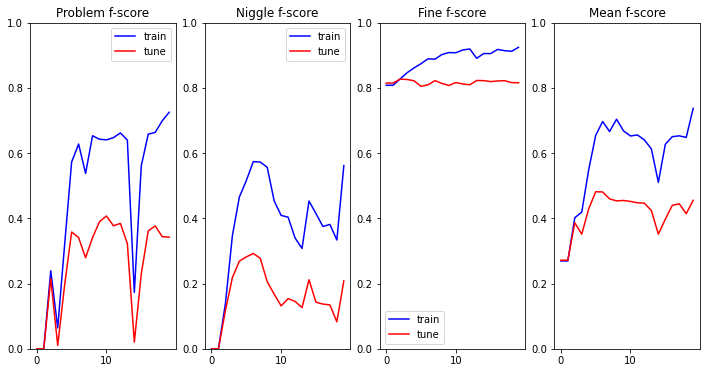

In [89]:
plot_history(train_history, tune_history)

Try ensemble model which combines CNN with BOW architecture

In [90]:
train_history, tune_history = run_model(nlp, "spacy.TextCatEnsemble.v2", drop=0.2, n_iter=15, min_batch=4.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	16.573	0.792		0.000	0.000	0.815	0.272	0.000	0.000	0.808	0.269
2	15.656	0.790		0.310	0.087	0.821	0.406	0.354	0.119	0.833	0.436
3	14.714	0.792		0.412	0.106	0.827	0.448	0.534	0.123	0.865	0.508
4	13.522	0.791		0.414	0.172	0.826	0.470	0.583	0.260	0.890	0.578
5	12.639	0.777		0.386	0.249	0.812	0.483	0.642	0.353	0.907	0.634
6	11.388	0.792		0.333	0.244	0.829	0.469	0.661	0.437	0.912	0.670
7	10.361	0.775		0.424	0.294	0.805	0.508	0.689	0.487	0.933	0.703
8	9.631	0.764		0.408	0.338	0.785	0.510	0.734	0.587	0.936	0.752
9	8.459	0.778		0.329	0.353	0.805	0.496	0.772	0.681	0.944	0.799
10	8.231	0.784		0.432	0.347	0.806	0.528	0.844	0.744	0.949	0.846
11	7.100	0.790		0.353	0.333	0.823	0.503	0.849	0.749	0.952	0.850
12	6.910	0.776		0.382	0.327	0.804	0.504	0.854	0.777	0.963	0.865
13	6.335	0.783		0.371	0.347	0.809	0.509	0.889	0.812	0.965	0.889
14	6.081	0.777		0.296	0.307	0.804	0

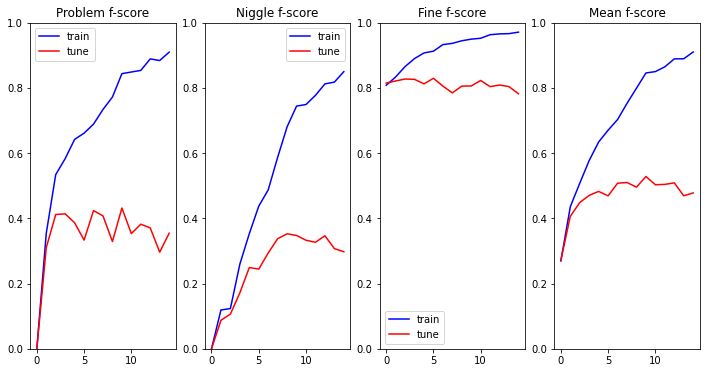

In [91]:
plot_history(train_history, tune_history)

Review of results obtained so far:

In [92]:
print('Model\t\tArchitecture\t\tDrop\tmin_batch\tmean f-score\titerations')
for run in runs:
    arch = run['architecture'].split('.')
    print(f"{run['model']}\t{arch[1]}\t\t{run['drop']}\t{run['min_batch']}\t\t{run['best_f']:.3}\t\t{run['best_iter']+1}")

Model		Architecture		Drop	min_batch	mean f-score	iterations
core_web_sm	TextCatCNN		0.2	4.0		0.489		6
core_web_lg	TextCatCNN		0.2	4.0		0.545		5
core_web_sm	TextCatCNN		0.2	2.0		0.492		12
core_web_sm	TextCatCNN		0.3	2.0		0.503		11
core_web_sm	TextCatCNN		0.4	2.0		0.482		7
core_web_sm	TextCatEnsemble		0.2	4.0		0.528		11


Observations:
* The large language model perfcorms significantly better than the small model
* Reducing the min-batch size makes a negligible difference
* Increasing the drop rate to 30% also makes a negligible difference, and increasing this further to 40% worsens the performance
* Using the ensemble architecture makes a significant improvement to the score
 
Combining these results for a final model with large language, 20% drop, 4.0 min_batch with ensemble architecture:

In [95]:
train_history, tune_history = run_model(nlp2, "spacy.TextCatEnsemble.v2", drop=0.2, n_iter=15, min_batch=4.0)

Training the model...
Iter	LOSS	mean_accuracy	f_score (tune):			f_score (train):
				Problem	Niggle	Fine	Mean	Problem	Niggle	Fine	Mean
1	16.609	0.789		0.342	0.000	0.821	0.388	0.402	0.000	0.827	0.410
2	15.090	0.796		0.435	0.024	0.827	0.429	0.519	0.038	0.854	0.471
3	13.738	0.789		0.449	0.203	0.826	0.493	0.610	0.310	0.885	0.602
4	12.222	0.796		0.438	0.278	0.829	0.515	0.652	0.404	0.903	0.653
5	11.225	0.794		0.446	0.291	0.826	0.521	0.712	0.534	0.920	0.722
6	10.079	0.782		0.432	0.342	0.807	0.527	0.736	0.651	0.935	0.774
7	8.996	0.771		0.430	0.308	0.795	0.511	0.813	0.720	0.949	0.827
8	7.516	0.762		0.380	0.322	0.784	0.495	0.786	0.695	0.952	0.811
9	7.433	0.776		0.402	0.299	0.797	0.499	0.825	0.748	0.957	0.843
10	6.852	0.779		0.403	0.271	0.805	0.493	0.848	0.775	0.960	0.861
11	6.751	0.779		0.400	0.304	0.804	0.503	0.903	0.834	0.968	0.902
12	5.454	0.789		0.410	0.274	0.815	0.500	0.916	0.854	0.970	0.913
13	4.860	0.787		0.381	0.250	0.811	0.481	0.933	0.858	0.966	0.919
14	4.580	0.775		0.398	0.268	0.798	0.

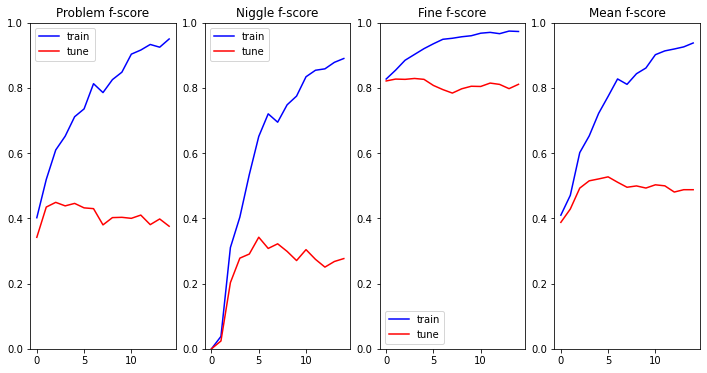

In [96]:
plot_history(train_history, tune_history)

Retrieve the model after 6 iterations:

In [101]:
if 'textcat' in nlp2.pipe_names:
    nlp2.remove_pipe('textcat')
textcat=nlp2.create_pipe( "textcat",
                    config={"exclusive_classes": True, "architecture": "spacy.TextCatEnsemble.v2"})
nlp2.add_pipe(textcat, last=True)
textcat.add_label("Problem")
textcat.add_label("Niggle")
textcat.add_label("Fine")
other_pipes = [pipe for pipe in nlp2.pipe_names if pipe != 'textcat']
with nlp2.disable_pipes(*other_pipes):
    optimizer = nlp2.begin_training()
    for i in range(6):
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp2.update(texts, annotations, sgd=optimizer, drop=0.2,losses=losses)

## 4. Evaluation<a id='s4'></a>

The best performance (judging by mean f-score) is TextCatEnsemble.v2 using the large language model with drop=0.2, stopping after 6 iterations.

And generate the final predictions from the test texts and build the confusion matrix

In [126]:
import numpy as np
import sklearn.metrics as metrics
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
predictions = []
actuals = []
docs = [nlp2.tokenizer(text) for text in test_texts]
for name, pipe in nlp2.pipeline:
    if name == 'textcat':
        textcat = pipe
confusion = np.matrix([[0,0,0],[0,0,0],[0,0,0]])
m_index = {'Problem': 0, "Niggle": 1, "Fine":2}
for i, doc in enumerate(textcat.pipe(docs)):
    gold = m_index[max(test_cats[i], key = test_cats[i].get)]
    pred = m_index[max(doc.cats, key = doc.cats.get)]
    predictions.append(pred)
    actuals.append(gold)
confusion_matrix = metrics.confusion_matrix(actuals,predictions)
print("Confusion matrix\n\nProblem  Niggle  Fine")
print(confusion_matrix)
print("\nNormalized by rows\n")
sum_of_rows = confusion_matrix.sum(axis=1)
print(confusion_matrix / sum_of_rows[:, np.newaxis])
fscore = metrics.f1_score(actuals,predictions,average=None)
print(f"\nF-scores\nProblem\t{fscore[0]:.3}\nNiggle\t{fscore[1]:.3}\nFine\t{fscore[2]:.3}\nMean\t{np.mean(fscore):.3}")

Confusion matrix

Problem  Niggle  Fine
[[  60   98   83]
 [  18  163  273]
 [  37  195 1124]]

Normalized by rows

[[0.249 0.407 0.344]
 [0.040 0.359 0.601]
 [0.027 0.144 0.829]]

F-scores
Problem	0.337
Niggle	0.358
Fine	0.793
Mean	0.496


Overall our model has achieved an f-score of 0.496. There is some serious confusion of categories taking place. From the normalized confusion matrix we can see that only 25% of Problems are identified as such. Likewise 60% of Niggles are classified as Fine. Let's have a look at some examples where the model got it wrong:

In [127]:
def example(actual, pred):
    a = m_index[actual]
    p = m_index[pred]
    examples = []
    for i in range(0,len(test_texts)):
        if actuals[i] == a and predictions[i] == p: 
            examples.append(test_texts[i])
    print(f"Error examples for actual={actual} and predicted={pred}\n")
    print(f"(1) {examples[0]}\n")
    print(f"(2) {examples[1]}\n")
    print(f"(3) {examples[2]}\n")

In [128]:
example("Problem","Niggle")

Error examples for actual=Problem and predicted=Niggle

(1) It sounds like it's Behringer.  Very fake, cheap sounding phaser, but it's all I need.  I got it mostly for that big airplane woosh, and running it in the loop, it does that fine.  The highs are kind of harsh, but if it is in front of the amp it can sound a little tame.

(2) I only just received these, but thought I'd give my first impression. I purchased headphones because I figured it was a more pleasant way to listen to music at work than in-ear type. I chose this model because they were on sale, seemed to be a diamond in the rough, and reviews indicated it would be good for large heads(I wear an XL hat size).The build is average. They don't feel flimsy in my hands, but you can see the plastic parts are nothing special, strength-wise. The padding for the headband is a little uneven on the seam, as you open up the headband to put the unit on your head, it sort of looks warped. The 3 meter cable is attached to the base of the

I am confused about the first 2 reviews. They really sound more like niggles than problems. (And who has time to write a review that long?!) The third one does sound like a problem, but the last phrase (which doesn't make sense to me) seems to add a positive tone.

In [129]:
example("Problem","Fine")

Error examples for actual=Problem and predicted=Fine

(1) The right pick is a personal preference. Nothing wrong with Dunlop Stubby Pick, but it's not for me. I bought a pack of 2.0mm  picks last year and loved them but left them in Florida when I went north. I forgot the name of my favorite pick and bought these by mistake.

(2) The version I picked came with a grounding wire, claiming that using the wire in conjunction with the brush would discharge all of the electrostatic-producing snap, crackles, and pops.  If you believe that, continue to do so, and maybe you'll imagine less surface noise than was the case before employing the device.  Speaking more pragmatically, I've found some use for the item only when loose, conspicuous debris has collected on the surface of a vinyl disc.

(3) Great concept....everything rolled into one product.  Winder, String cutter and end pin remover.  The price is fair for all that.



The first review really is an example of reviewer preference rather than objective product rating. The second is sardonically worded, and the cues of dissatisfaction would be hard to pick up. The third leaves me baffled! I checked the source data to make sure I had got it right - and yes the reviewer rated it 3. Hard to please!

In [132]:
example("Niggle", "Fine")

Error examples for actual=Niggle and predicted=Fine

(1) This is definitely a must have for the home recording enthusiast, especially if you are using any of the XENYX or other Behringer brand mixers (it also works with other mixers as well).This is a great, inexpensive, way to  get your analog audio into your digital recording software. It works on Windows, Mac and Linux (at least it did for me).

(2) The stand arrived very quickly.  Came in a few pieces but took all of about 45 seconds to put it together.  the neck is adjustable which will allow it to hold multiple sized guitar.  Excellent product.

(3) Nice picks, much brighter sounding than the jazz 3 nylon picks. I prefer the jazz 3s since thr jazz 3s are warmer sounding and wear resistant. but these pitch blacks are not bad. They do wear down quickly but a dozen should last a good amount of time.  This pick does what jazz picks are suppose to do and in my university's jazz ensemble the three tips are useful and makes playing diff

I cannot detect a niggle at all in these reviews. I suspect they come from reviewers with a philosophy that nothing deserves a 5 unless it is positively amazing.

## 5. Conclusions<a id='s5'></a>
On deeper inspection of these failure cases it seems that the model may well have done a lot better than the f-score indicates. In particular the meaning of the scoring system seems to be open to wide interpretation.

If the goal is to highlight actual problems that might merit attention, it does seem that the review text could be a better source of information rather than simply looking at the score.